In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [287]:
spark = SparkSession.builder.appName('fp').getOrCreate()

In [288]:
data = "clean_Spotify_Youtube.csv"
df = spark.read.csv(data, header=True, inferSchema=True)
df = df.select("Track", "Album", "Danceability", "Energy", "Key", "Loudness", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence", "Tempo", "Likes", "Stream", "Views")

# cast cols as float bc they are initially parsed as str
df = df.withColumn("Danceability", col("Danceability").cast("float"))
df = df.withColumn("Energy", col("Energy").cast("float"))
df = df.withColumn("Key", col("Key").cast("float"))
df = df.withColumn("Loudness", col("Loudness").cast("float"))
df = df.withColumn("Speechiness", col("Speechiness").cast("float"))
df = df.withColumn("Acousticness", col("Acousticness").cast("float"))
df = df.withColumn("Instrumentalness", col("Instrumentalness").cast("float"))
df = df.withColumn("Liveness", col("Liveness").cast("float"))
df = df.withColumn("Valence", col("Valence").cast("float"))
df = df.withColumn("Tempo", col("Tempo").cast("float"))
df = df.withColumn("Likes", col("Likes").cast("float"))
df = df.withColumn("Stream", col("Stream").cast("float"))
df = df.withColumn("Views", col("Views").cast("float"))

# remove any rows with null values
df = df.dropna()

df = df.withColumn("LikeCategories",
                     when(col("Likes") < 1_000, "0-1K")
                    .when(col("Likes") < 5_000, "1K-5K")
                    .when(col("Likes") < 10_000, "5K-10K")
                    .when(col("Likes") < 50_000, "10K-50K")
                    .when(col("Likes") < 100_000, "50K-100K")
                    .when(col("Likes") < 500_000, "100K-500K")
                    .when(col("Likes") < 1_000_000, "500K-1M")
                    .when(col("Likes") < 5_000_000, "1M-5M")
                    .when(col("Likes") < 10_000_000, "5M-10M")
                    .when(col("Likes") < 50_000_000, "10M-50M")
                    .when(col("Likes") < 100_000_000, "50M-100M")
                    .when(col("Likes") < 500_000_000, "100M-500M")
                    .when(col("Likes") < 1_000_000_000, "500M-1B")
                    .when(col("Likes") < 5_000_000_000, "1B-5B")
                    .when(col("Likes") < 10_000_000_000, "5B-10B")
                    .otherwise("10B+")
)

df = df.withColumn("StreamCategories",
                     when(col("Stream") < 1_000, "0-1K")
                    .when(col("Stream") < 5_000, "1K-5K")
                    .when(col("Stream") < 10_000, "5K-10K")
                    .when(col("Stream") < 50_000, "10K-50K")
                    .when(col("Stream") < 100_000, "50K-100K")
                    .when(col("Stream") < 500_000, "100K-500K")
                    .when(col("Stream") < 1_000_000, "500K-1M")
                    .when(col("Stream") < 5_000_000, "1M-5M")
                    .when(col("Stream") < 10_000_000, "5M-10M")
                    .when(col("Stream") < 50_000_000, "10M-50M")
                    .when(col("Stream") < 100_000_000, "50M-100M")
                    .when(col("Stream") < 500_000_000, "100M-500M")
                    .when(col("Stream") < 1_000_000_000, "500M-1B")
                    .when(col("Stream") < 5_000_000_000, "1B-5B")
                    .when(col("Stream") < 10_000_000_000, "5B-10B")
                    .otherwise("10B+")
)

df.show(10)

+--------------------+--------------------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-------+---------+------------+------------+--------------+----------------+
|               Track|               Album|Danceability|Energy| Key|Loudness|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|    Likes|      Stream|       Views|LikeCategories|StreamCategories|
+--------------------+--------------------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-------+---------+------------+------------+--------------+----------------+
|      Feel Good Inc.|          Demon Days|       0.818| 0.705| 6.0|  -6.679|      0.177|     0.00836|         0.00233|   0.613|  0.772|138.559|6220896.0|1.04023488E9|  6.935552E8|        5M-10M|           1B-5B|
|     Rhinestone Eyes|       Plastic Beach|       0.676| 0.703| 8.0|  -5.815|     0.0302|      0.0869|         6.87E-4|  0.0463|  0.852| 92.761|1079

In [289]:
df.select("Likes", "Stream").describe().show(10)
df.select("Likes", "Stream").summary().show(10)

+-------+------------------+--------------------+
|summary|             Likes|              Stream|
+-------+------------------+--------------------+
|  count|             19535|               19535|
|   mean| 670287.7322754031|1.3745607356902996E8|
| stddev|1806130.7642988004|2.4657690829661256E8|
|    min|               0.0|              6574.0|
|    max|       5.0788652E7|        3.38652032E9|
+-------+------------------+--------------------+

+-------+------------------+--------------------+
|summary|             Likes|              Stream|
+-------+------------------+--------------------+
|  count|             19535|               19535|
|   mean| 670287.7322754031|1.3745607356902996E8|
| stddev|1806130.7642988004|2.4657690829661256E8|
|    min|               0.0|              6574.0|
|    25%|           22305.0|         1.7820816E7|
|    50%|          127318.0|         4.9951052E7|
|    75%|          524943.0|        1.39674256E8|
|    max|       5.0788652E7|        3.38652032E9|

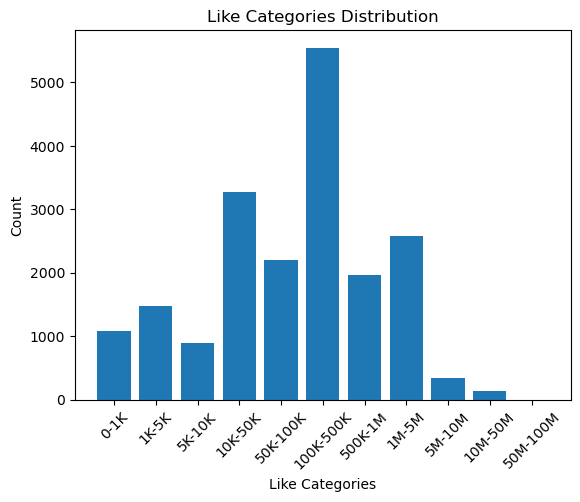

In [290]:
# category_order = [
#     "0-1K", "1K-10K", "10K-100K", "100K-1M",
#     "1M-10M", "10M-100M", "100M-1B", "1B-10B", "10B+"
# ]

category_order = [
    "0-1K", "1K-5K", "5K-10K", "10K-50K", "50K-100K",
    "100K-500K", "500K-1M", "1M-5M", "5M-10M",
    "10M-50M", "50M-100M", "100M-500M", "500M-1B",
    "1B-5B", "5B-10B", "10B+"
]

like_df = (
    df.groupBy("LikeCategories")
        .count()
        .toPandas()
        .set_index("LikeCategories")
        .reindex(category_order)
        .reset_index()
)


# plot the like categories
plt.bar(like_df["LikeCategories"], like_df["count"])
plt.xlabel("Like Categories")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Like Categories Distribution")   
plt.show()

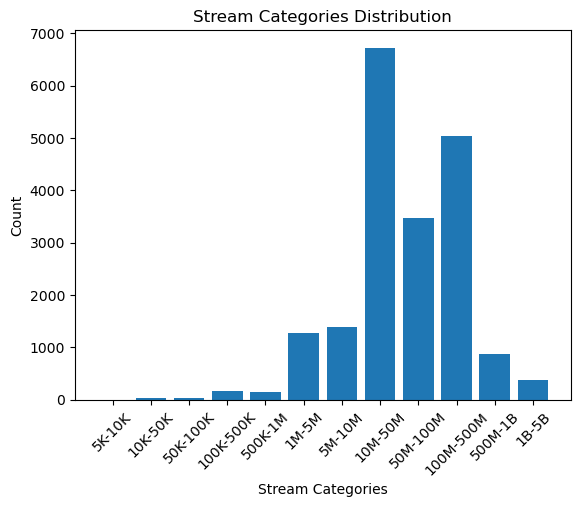

In [291]:
stream_df = (
    df.groupBy("StreamCategories")
        .count()
        .toPandas()
        .set_index("StreamCategories")
        .reindex(category_order)
        .reset_index()  
)

# plot the stream categories
plt.bar(stream_df["StreamCategories"], stream_df["count"])
plt.xlabel("Stream Categories")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Stream Categories Distribution")
plt.show()

In [292]:
trainDF, testDF = df.randomSplit([0.8, 0.2], seed=42)

vectorAssembler = VectorAssembler(inputCols=["Danceability", "Energy", "Key", "Loudness", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence", "Tempo"], outputCol="features")
vecTrainDF = vectorAssembler.transform(trainDF)

In [305]:
likeLabelIndexer = StringIndexer(inputCol="LikeCategories", outputCol="LikeLabel")
# likeModel = DecisionTreeClassifier(featuresCol="features", labelCol="LikeLabel")
likeModel = RandomForestClassifier(featuresCol="features", labelCol="LikeLabel", numTrees=50)

streamLabelIndexer = StringIndexer(inputCol="StreamCategories", outputCol="StreamLabel")
# streamModel = DecisionTreeClassifier(featuresCol="features", labelCol="StreamLabel")
streamModel = RandomForestClassifier(featuresCol="features", labelCol="StreamLabel", numTrees=50)

In [306]:
def make_model(labelIndexer, model):
    pipeline = Pipeline(stages=[vectorAssembler, labelIndexer, model])
    model = pipeline.fit(trainDF)
    return model    

In [307]:
streamModel = make_model(streamLabelIndexer, streamModel)
likeModel = make_model(likeLabelIndexer, likeModel)

In [308]:
# evaluate the model with function cuz im lazy
def evaluate_model(model, testDF, labelCol):
    predDF = model.transform(testDF)
    evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predDF)
    print(f"Accuracy on test data = {accuracy}")
    return predDF


def plot_confusion_matrix(predDF, labelCol, log_scale=False):
    y_true = predDF.select(labelCol).toPandas()
    y_pred = predDF.select("prediction").toPandas()
    
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    
    if log_scale and matrix.max() > 0:
        # add 1 so no log(0)
        plot_data = np.log10(matrix + 1)
        cbar_label = 'log10(count + 1)'
    else:
        plot_data = matrix
        cbar_label = 'Count'
    
    # Create the heatmap with appropriate settings
    ax = sns.heatmap(plot_data, annot=matrix, fmt='d', cmap='Blues')
    
    # Add colorbar label
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar_label)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {labelCol}" + (" (Log Scale)" if log_scale else ""))
    plt.tight_layout()
    plt.show()

Accuracy on test data = 0.2920517560073937


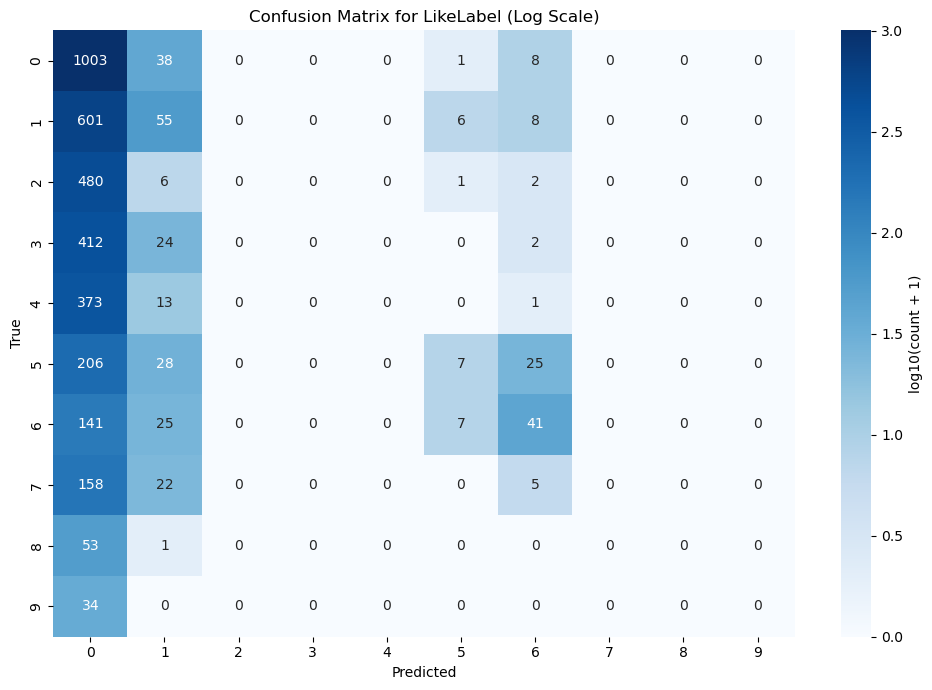

In [309]:
# like model evaluation
likePreds = evaluate_model(likeModel, testDF, "LikeLabel")
plot_confusion_matrix(likePreds, "LikeLabel", log_scale=True)

Accuracy on test data = 0.3456561922365989


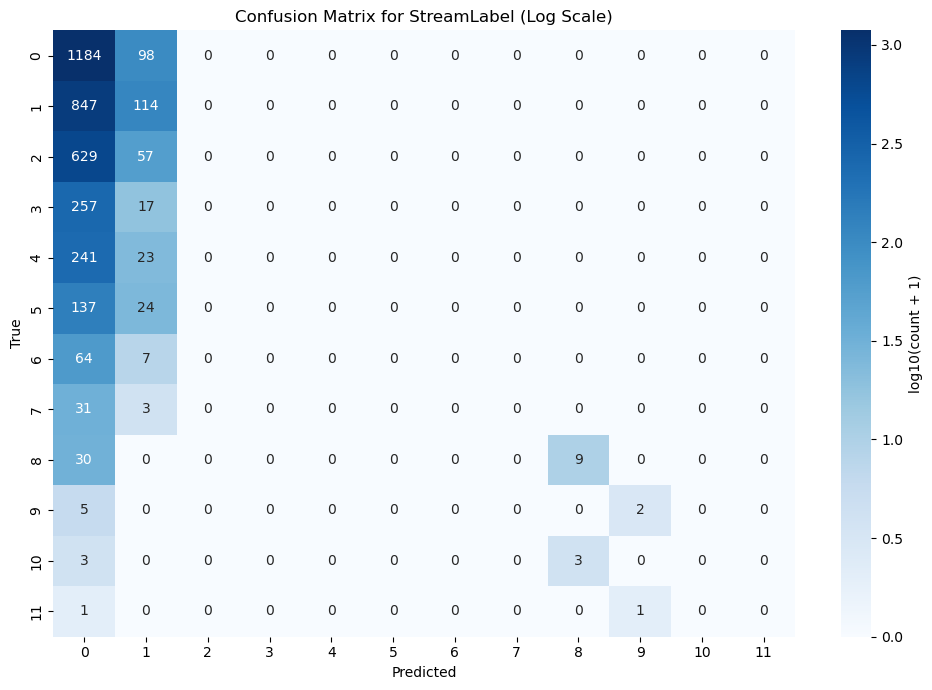

In [304]:
# stream model evaluation
streamPreds = evaluate_model(streamModel, testDF, "StreamLabel")  
plot_confusion_matrix(streamPreds, "StreamLabel", log_scale=True)